In [3]:
import torch
import matplotlib.pyplot as plt
import deepxde as dde
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [5]:
# define PDE, boundary conditions and loading

# x ~ input: x[:,0] - spatial coordinates, 1D, subsequently referred to as x in comments
#            x[:,1] - temporal coordinates, 1D, , subsequently referred to as t in comments
# 
# y ~ output: y[:,0] ~ w, displacement            


def d_xx(x, y):

    # compute dw/dx^2 and dw/dt^2

    return dde.grad.hessian(y, x)


def d_xxx(x, y):

    # compute third derivate of x w.r.t. to x and t

    return dde.grad.jacobian(d_xx(x, y), x)


def pde(x, y):

    # dw/dx^4 + dw/dt^2 - p(x,t) = 0

    dy_xx = d_xx(x, y)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    d_tt = dde.grad.hessian(y, x, i=1, j=1)

    return dy_xxxx + d_tt + p(x)

# loading

def p(x):

    x_t = x[:,1:2]
    x_s = x[:,0:1]

    return -torch.matmul(torch.ones(x_s.size(dim=0),1),torch.transpose(torch.cos(torch.pi*x_t),0,1)) 

In [15]:
# define domain

l_spatial = 0
r_spatial = 1
l_time = 0
r_time = 0.5

L = 1

geom = dde.geometry.Interval(l_spatial,r_spatial)
timedomain = dde.geometry.TimeDomain(l_time,r_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


In [16]:
# boundary conditions

def boundary_l_space(x, on_boundary):
    return on_boundary and np.isclose(x[0], l_spatial)


def boundary_r_space(x, on_boundary):
    return on_boundary and np.isclose(x[0], r_spatial)
    

bc1 = dde.DirichletBC(geomtime, lambda x: 0, boundary_l_space)
bc2 = dde.OperatorBC(geomtime, lambda x, y, _: d_xx(x, y), boundary_l_space)
bc3 = dde.DirichletBC(geomtime, lambda x: 0, boundary_r_space)
bc4 = dde.OperatorBC(geomtime, lambda x, y, _: d_xx(x, y), boundary_r_space)

# initial conditions

ic1 = dde.IC(geomtime, lambda x: 0 , lambda _, on_initial: on_initial) #torch.sin(torch.pi*torch.from_numpy(x[:,0:1]).to(device))
ic2 = dde.OperatorBC(
        geomtime,
        lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
         lambda _, on_initial: on_initial
    )

In [8]:
# create problem dataset & define model 
dde.config.set_default_float("float64")

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, bc3, bc4, ic1, ic2],
    num_domain=2000,
    num_boundary=100,
    num_initial=100,
    #solution=sol,
    num_test=1000,
)

layer_size = [2] + [100] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

lw = [10, 1, 1, 1, 1, 1, 1]

model = dde.Model(data, net)
model.compile("adam", lr=0.0001, loss_weights=lw)

model.train(epochs=100, display_every=100)

model.compile("L-BFGS", loss_weights=lw)

losshistory, train_state = model.train(epochs=20000, display_every=100)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Set the default float type to float64
Compiling model...
'compile' took 2.883046 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [5.37e+00, 1.01e-02, 2.08e-04, 4.30e-02, 9.22e-05, 1.83e-03, 1.12e-02]    [5.33e+00, 1.01e-02, 2.08e-04, 4.30e-02, 9.22e-05, 1.83e-03, 1.12e-02]    []  


/dss/dsshome1/06/di38sud/micromamba/envs/hybrid_models/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100       [5.32e+00, 4.47e-05, 8.86e-06, 8.22e-05, 2.99e-04, 5.30e-05, 5.46e-04]    [5.29e+00, 4.47e-05, 8.86e-06, 8.22e-05, 2.99e-04, 5.30e-05, 5.46e-04]    []  

Best model at step 100:
  train loss: 5.32e+00
  test loss: 5.29e+00
  test metric: []

'train' took 4.920942 s

Compiling model...
'compile' took 0.000314 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
100       [5.32e+00, 4.47e-05, 8.86e-06, 8.22e-05, 2.99e-04, 5.30e-05, 5.46e-04]    [5.29e+00, 4.47e-05, 8.86e-06, 8.22e-05, 2.99e-04, 5.30e-05, 5.46e-04]    []  


KeyboardInterrupt: 

In [22]:
def pde_new(x, y):

    # dw/dx^4 + dw/dt^2 - p(x,t) = 0
    
    dy_xxxx = dde.grad.hessian(y[:,1:2], x, i=0, j=0)
    dy_tt = dde.grad.hessian(y[:,0:1], x, i=1, j=1)
    dy_xx = dde.grad.hessian(y[:,0:1], x, i=0, j= 0)

    return dy_xxxx + dy_tt - p(x) + dy_xx - y[:,1:2]

bc5 = dde.DirichletBC(geomtime, lambda x, y: y[0,0:1], boundary_l_space)
bc6 = dde.DirichletBC(geomtime, lambda x, y: y[0,1:2], boundary_l_space)
bc7 = dde.DirichletBC(geomtime, lambda x, y: y[-1,0:1], boundary_r_space)
bc8 = dde.DirichletBC(geomtime, lambda x, y: y[-1,1:2], boundary_r_space)

# initial conditions

#ic1 = dde.IC(geomtime, lambda x: 0 , lambda _, on_initial: on_initial) #torch.sin(torch.pi*torch.from_numpy(x[:,0:1]).to(device))
#ic2 = dde.OperatorBC(
#        geomtime,
#        lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1),
#         lambda _, on_initial: on_initial
#    )

Set the default float type to float64
Compiling model...
'compile' took 0.000139 s



Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.12e+01, 1.35e-05, 9.25e-08, 3.99e-02, 8.91e-03, 1.41e-02, 1.10e-04]    [1.12e+01, 1.35e-05, 9.25e-08, 3.99e-02, 8.91e-03, 1.41e-02, 1.10e-04]    []  
100       [1.23e+00, 6.04e-03, 1.85e-04, 9.95e-03, 9.34e-06, 2.81e-03, 1.84e-02]    [1.23e+00, 6.04e-03, 1.85e-04, 9.95e-03, 9.34e-06, 2.81e-03, 1.84e-02]    []  
200       [1.13e+00, 1.33e-03, 1.49e-04, 9.87e-05, 2.21e-04, 2.90e-04, 8.99e-04]    [1.15e+00, 1.33e-03, 1.49e-04, 9.87e-05, 2.21e-04, 2.90e-04, 8.99e-04]    []  
300       [1.07e+00, 1.02e-03, 2.61e-04, 1.21e-05, 2.14e-04, 3.14e-04, 4.17e-04]    [1.10e+00, 1.02e-03, 2.61e-04, 1.21e-05, 2.14e-04, 3.14e-04, 4.17e-04]    []  
400       [1.03e+00, 9.51e-04, 4.33e-04, 3.63e-05, 1.63e-04, 3.15e-04, 6.31e-04]    [1.07e+00, 9.51e-04, 4.33e-04, 3.63e-05, 1.63e-04, 3.15e-04, 6.31e-04]    [

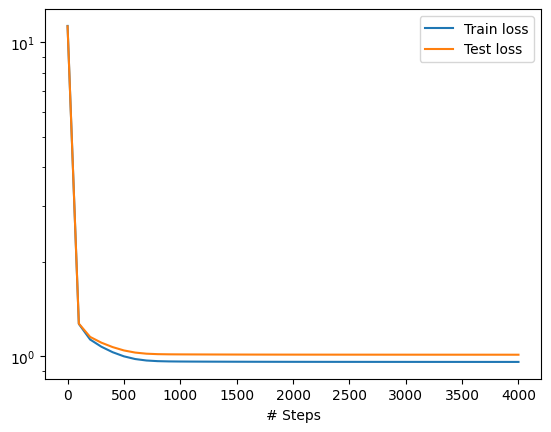

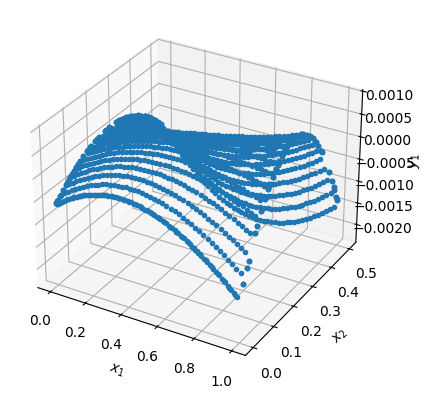

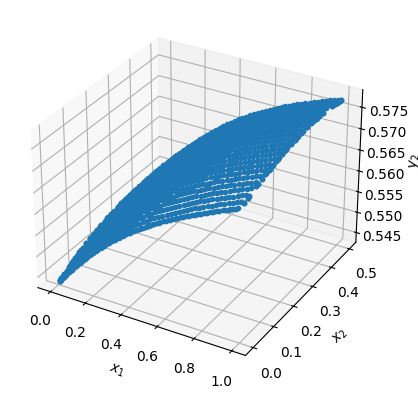

In [23]:
# create problem dataset & define model 
dde.config.set_default_float("float64")

data_new = dde.data.TimePDE(
    geomtime,
    pde_new,
    [bc1, bc2, bc3, bc4, ic1, ic2],
    num_domain=3000,
    num_boundary=100,
    num_initial=100,
    #solution=sol,
    num_test=1000,
)

layer_size = [2] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net_new = dde.maps.FNN(layer_size, activation, initializer)

lw = [10, 1, 1, 1, 1, 1, 1]

model_new = dde.Model(data_new, net_new)
model_new.compile("adam", lr=0.0001, loss_weights=lw)

#model_new.train(epochs=4000, display_every=100)
#model_new.compile("L-BFGS", loss_weights=lw)

losshistory, train_state = model_new.train(epochs=4000, display_every=100)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)